# Calcul de la constante de Lifschitz

In [1]:
# importation
import numpy as np
from torch.autograd import Variable
import torch
import matplotlib.pyplot as plt
%matplotlib inline
# local
from FBResNet.myfunc import Physics
from FBResNet.myfunc import MyMatmul
from FBResNet.main import FBRestNet
from FBResNet.model import MyModel
from FBResNet.posttreat import Export_hyper

### Parametres

In [2]:
exp1 = FBRestNet(experimentation=Physics(2000,50,1,1), nb_blocks=20, noise = 0.05,\
                 folder = './', im_set="Set1",batch_size=[200,1],\
                 lr=1e-3, nb_epochs=[20,1])

### Data set
On entraine sur 300 données et on évalue sur 100.

In [3]:
train_set, val_set = exp1.CreateDataSet()
train_set, val_set = exp1.LoadDataSet()

### Trainings
Entrainement sur 20 époques, learning rate de $10^{-3}$.
On trace la constante de Lipschitz au cours de l' entrainement.

In [4]:
#exp1.train(train_set,val_set,save_model=True)

### Affichage de résultats

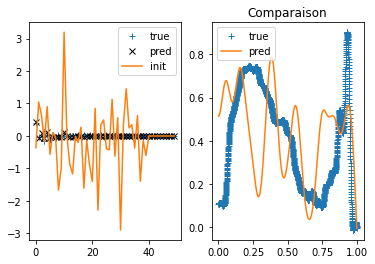

Erreur relative :  1.7022883704221585
Erreur initiale :  2.4173464922976673


In [5]:
err = exp1.test(train_set)

### Test with gaussian

<class 'str'>
x-xp/x = 0.9853295262888031


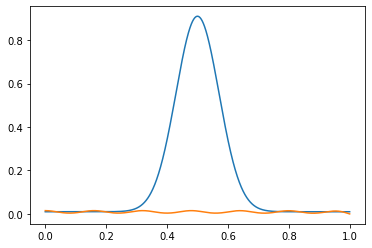

In [6]:
exp1.test_gauss(noise=0.1)

### Lipschitz constant

In [7]:
exp1.model.Lipschitz(opt1="semi",opt2="entree11")

0.04861863395389527

In [8]:
exp1.model.Lipschitz(opt1="total",opt2="entree11")

1.0274524238040599

In [9]:
exp1.model.Lipschitz(opt1="semi",opt2="entree01")

0.0003992416012242836

In [10]:
exp1.model.Lipschitz(opt1="total",opt2="entree01")

0.16682098666060774

### TEST ON OTHER FUNCTIONS